# LowHighRegression MLFLow experiments


To install conda and binance packages to this notebook uncomment the code below

In [1]:
#%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
# %pip install plotly==5.9.0
# %pip install twisted
# %pip install binance-connector==1.13.0
# %pip install pandas
# %pip install scikit-learn
#%pip install tensorflow==2.16.1
#%pip install keras==3.3.3
#%pip install keras==2.11.0
#%pip install scrapy==2.11.2
#%pip install itemloaders==1.2.0
# %pip install keras
# %pip install scikeras
# %pip install keras-tuner
# %pip install boto3
#%pip install python-dotenv
import os
import sys

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
# Read .env variable with s3 access keys
#%load_ext dotenv
#%dotenv

## App parameters

In [2]:
# env file
#env_file='local.env'
env_file='.env'
from dotenv import load_dotenv
dotenv_path = os.path.abspath(env_file) #travels up a level to find the .env
load_dotenv(dotenv_path)


ticker="BTC-USDT"
data_dir='./data'
history_days=360

# Features: how much candles of each period to include
features_candles_periods = ['5min', '10min', '20min', '30min', '40min']
target_period = '10min'

# features_candles_periods = ['5min', '10min', '15min', '30min', '40min']
# target_period = '5min'
profit_loss_ratio = 3.5

test_days = 15

# Signal and profit calculation parameteters
# profit_loss_ratio = 2
# take_profit_min_coeff = 0.0012
# stop_loss_max_coeff = 0.0024
# take_profit_max_coeff = 0.005
# stop_loss_min_coeff = 0.00012
# comission_pct = 0.012
# price_precision = 2


take_profit_min_coeff = 0.0012
stop_loss_max_coeff = 0.0048
take_profit_max_coeff = 0.005
stop_loss_min_coeff = 0.00012
comission_pct = 0.012
price_precision = 2

comission = 0.01 * comission_pct

experiment_name = 'LowHighRegression'
run_name =  f'LHR target: {target_period}, sharp: {profit_loss_ratio}, periods:{features_candles_periods},  history {history_days}, test {test_days}'
do_log_experiment = False
do_log_model = False



In [3]:
# Indicators' params for each candle period
features_params = {
    "5min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "10min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "20min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "30min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "40min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
}
# Default
features_params = None
# features_params = {
#     "5min":
#         {
#             "cca": {"window": 20},
#             "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
#             "adx": {"window": 14},
#             "rsi": {"window": 14},
#             "stoch": {"window": 14, "smooth_window": 3},
#             "macd": {"slow": 26, "fast": 12}
#         },
#     "10min":
#         {
#             "cca": {"window": 20},
#             "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
#             "adx": {"window": 14},
#             "rsi": {"window": 14},
#             "stoch": {"window": 14, "smooth_window": 3},
#             "macd": {"slow": 26, "fast": 12}
#         },
#     "20min":
#         {
#             "cca": {"window": 20},
#             "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
#             "adx": {"window": 14},
#             "rsi": {"window": 14},
#             "stoch": {"window": 14, "smooth_window": 3},
#             "macd": {"slow": 26, "fast": 12}
#         },
#     "30min":
#         {
#             "cca": {"window": 20},
#             "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
#             "adx": {"window": 14},
#             "rsi": {"window": 14},
#             "stoch": {"window": 14, "smooth_window": 3},
#             "macd": {"slow": 26, "fast": 12}
#         },
#     "40min":
#         {
#             "cca": {"window": 20},
#             "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
#             "adx": {"window": 14},
#             "rsi": {"window": 14},
#             "stoch": {"window": 14, "smooth_window": 3},
#             "macd": {"slow": 26, "fast": 12}
#         },
# }

## Feature engineering
Read data from bot's history, resample to equal intervals, create X, y

### Read candles from history

In [4]:
from tools.DataTool import DataTool
candles_1min = DataTool.read_last_candles(ticker, os.path.join(data_dir, "candles"), history_days)
candles_1min.tail()

close_time           open_time    ticker interval     open     high      low    close    vol
close_time                                                                                                               
2024-05-28 17:09:00 2024-05-28 17:09:00 2024-05-28 17:08:00  BTC-USDT     1min  67885.8  67900.0  67868.3  67887.8  11456
2024-05-28 17:10:00 2024-05-28 17:10:00 2024-05-28 17:09:00  BTC-USDT     1min  67884.1  67908.9  67873.0  67889.0   1472
2024-05-28 17:11:00 2024-05-28 17:11:00 2024-05-28 17:10:00  BTC-USDT     1min  67888.9  67943.1  67874.5  67919.4   1704
2024-05-28 17:12:00 2024-05-28 17:12:00 2024-05-28 17:11:00  BTC-USDT     1min  67919.3  68035.2  67919.3  68035.2  11396
2024-05-28 17:13:00 2024-05-28 17:13:00 2024-05-28 17:12:00  BTC-USDT     1min  68035.2  68035.2  68019.5  68026.1   2600

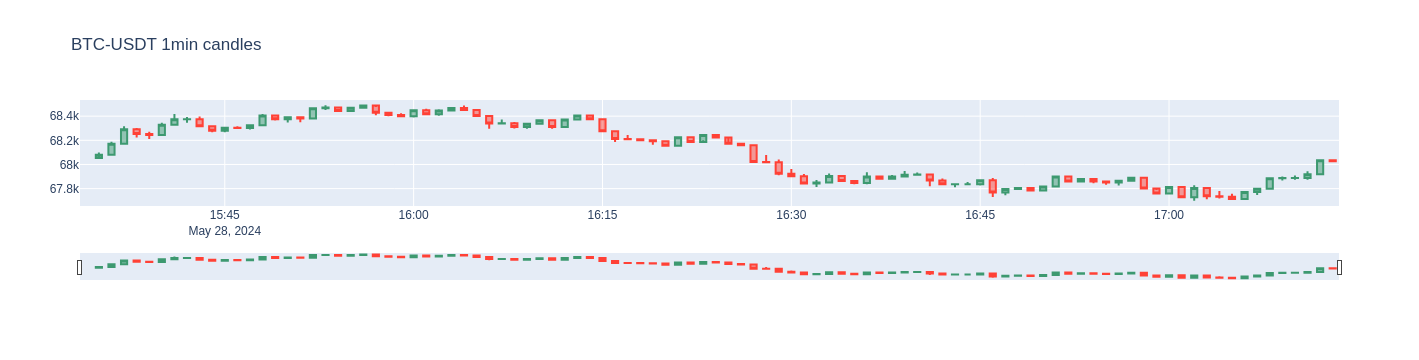

In [5]:
from tools.PlotTool import PlotTool
PlotTool.plot_candles(candles_1min.tail(100), '1min')

### Build features and targets

In [6]:
sys.path.append("pytrade2/pytrade2")
from pytrade2.pytrade2.strategy.features.CandlesFeatures import CandlesFeatures
from pytrade2.pytrade2.strategy.features.MultiIndiFeatures import MultiIndiFeatures
from pytrade2.pytrade2.strategy.features.LowHighTargets import LowHighTargets

def candles_by_periods_of(candles_1min: pd.DataFrame, periods) -> dict[str, pd.DataFrame]:
    """ Create candles_by_periods """
    out = {}
    for period in periods:
        out[period] = candles_1min.resample(period).agg({'open_time': 'first',
                                                             'close_time': 'last',
                                                             'open': 'first',
                                                             'high': 'max',
                                                             'low': 'min',
                                                             'close': 'last',
                                                             'vol': 'max'
                                                        })
    return out
 
# Candles by periods dictionary
candles_by_period = candles_by_periods_of(candles_1min, features_candles_periods)
print('Candles counts: %s' % {period: len(df) for period, df in candles_by_period.items()})

# Features no diff

features = MultiIndiFeatures.multi_indi_features(candles_by_period, features_params)
targets = LowHighTargets.fut_lohi(candles_by_period[target_period], target_period)
features = features.dropna()
targets = targets.dropna()
features = features[features.index.isin(targets.index)]
targets = targets[targets.index.isin(features.index)]
#features.tail()
#targets.tail(100)
#targets.info()
#targets[targets.isna()].tail()


Candles counts: {'5min': 103599, '10min': 51800, '20min': 25900, '30min': 17267, '40min': 12950}


### Train test split

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

def create_pipe(x, y) -> (Pipeline, Pipeline):
    """ Create feature and target pipelines to use for transform and inverse transform """

    time_cols = [col for col in x.columns if col.startswith("time")]
    float_cols = list(set(x.columns) - set(time_cols))

    x_pipe = Pipeline(
        [("xscaler", ColumnTransformer([("xrs", StandardScaler(), float_cols)], remainder="passthrough")),
         ("xmms", MaxAbsScaler())])
    x_pipe.fit(x)

    y_pipe = Pipeline(
        [("yrs", StandardScaler()),
         ("ymms", MaxAbsScaler())])
    y_pipe.fit(y)
    return x_pipe, y_pipe


In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt

def train_test_split(x, y, test_days=14):
    """ In addition to train_test_split, create pipeline for reverse transform in future"""
    #test_index = int(len(x)*(1-test_size))
    
    test_index = max(x.index) - pd.Timedelta(days=test_days)
    is_test = (x.index >= test_index)
    is_train = (x.index < test_index)
    
    x_train, y_train, x_test, y_test = x[is_train], y[is_train], \
        x[is_test], y[is_test]
    
    #test_index = int(len(x)*(1-test_size))

    # Split df to train/test
    # x_train, y_train, x_test, y_test = x.iloc[:test_index], y.iloc[:test_index], \
    #     x.iloc[test_index:], y.iloc[test_index:]

    # Create pipeline to transform/reverse transform
    x_pipe, y_pipe = create_pipe(x_train, y_train)
    return x_pipe, y_pipe, x_train, y_train, x_test, y_test


x_pipe, y_pipe, x_train, y_train, x_test, y_test = train_test_split(features, targets, test_days=test_days)

## Model creation and training

### Create model

In [9]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from sklearn.linear_model import LinearRegression

model_name='MultiOutputRegressorLgb'
import mlflow
from mlflow import MlflowClient

#mlflow.set_tracking_uri('http://localhost:5000')
mlflow_client = MlflowClient()

def create_model_linreg():
    
    model = LinearRegression()
    model = MultiOutputRegressor(model)
    print(f'Created new model {model}')
    return model

def create_model_keras(X_size, y_size):
    model = Sequential()
    model.add(Input(shape=(X_size,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(y_size, activation='linear'))
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

    # Load weights
    #self.model_persister.load_last_model(model)
    model.summary()
    return model


def create_model_lgb():
    """ MultiOutputRegressor with lgb model. """
    
    lgb_model = lgb.LGBMRegressor(verbose=-1)
    model = MultiOutputRegressor(lgb_model)
    print(f'Created new model {model}')
    return model

def ensure_model(model_name):
    versions = mlflow_client.search_model_versions(f"name='{model_name}'")

    if versions:
        version = versions[-1]
        model = mlflow.sklearn.load_model(versions[-1].source)
        model_url = f'models:/{model_name}/{version.version}'
    else:
        model = create_model()
        model_url = None
    return model, model_url

#model, model_url = ensure_model(model_name)
#print(model_url)
#model = create_model(len(features.columns), len(targets.columns))
model = create_model_lgb()


2024-05-28 20:18:14.488284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 20:18:15.275416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Created new model MultiOutputRegressor(estimator=LGBMRegressor(verbose=-1))


### Fit, predict

In [10]:
model.fit(x_pipe.transform(x_train), y_pipe.transform(y_train))

# Predict and inverse transform to dataframe
y_pred = model.predict(x_pipe.transform(x_test))
y_pred = y_pipe.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred, columns = y_test.columns, index = y_test.index)
y_pred.tail()

fut_low_diff  fut_high_diff
close_time                                      
2024-05-28 16:20:00   -105.377047     270.926791
2024-05-28 16:30:00   -198.720003      90.651074
2024-05-28 16:40:00   -131.177667     158.315787
2024-05-28 16:50:00   -108.461963     110.049896
2024-05-28 17:00:00   -229.153135     136.304824

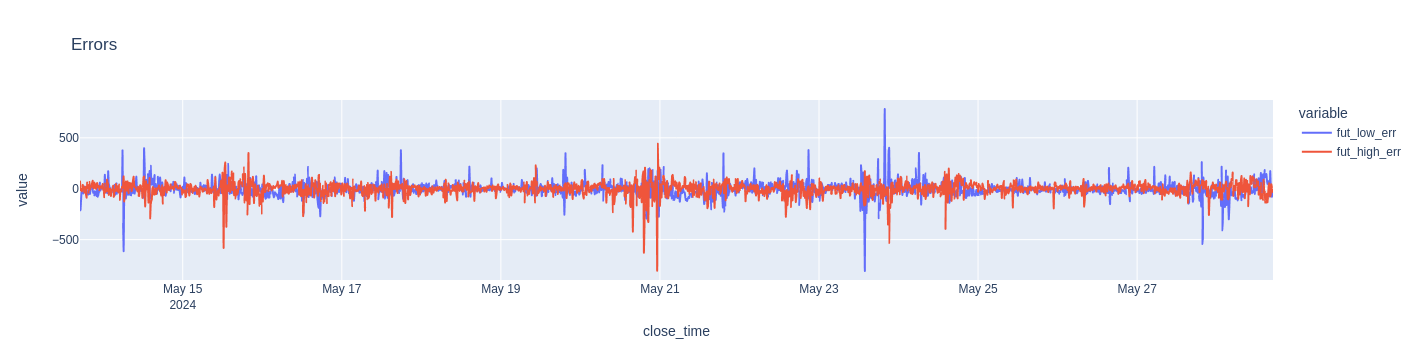

In [11]:
import plotly as py
import plotly.express as px
from plotly import graph_objects as go
# Remove plotly warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_y_pred_err(y_test, y_pred):
    err = pd.DataFrame()
    err['fut_low_err'] = y_pred['fut_low_diff'] - y_test['fut_low_diff']
    err['fut_high_err'] = y_pred['fut_high_diff'] - y_test['fut_high_diff']
    px.line(err, title='Errors').show()

plot_y_pred_err(y_test, y_pred)


# Evaluate the model

### Trading emulation

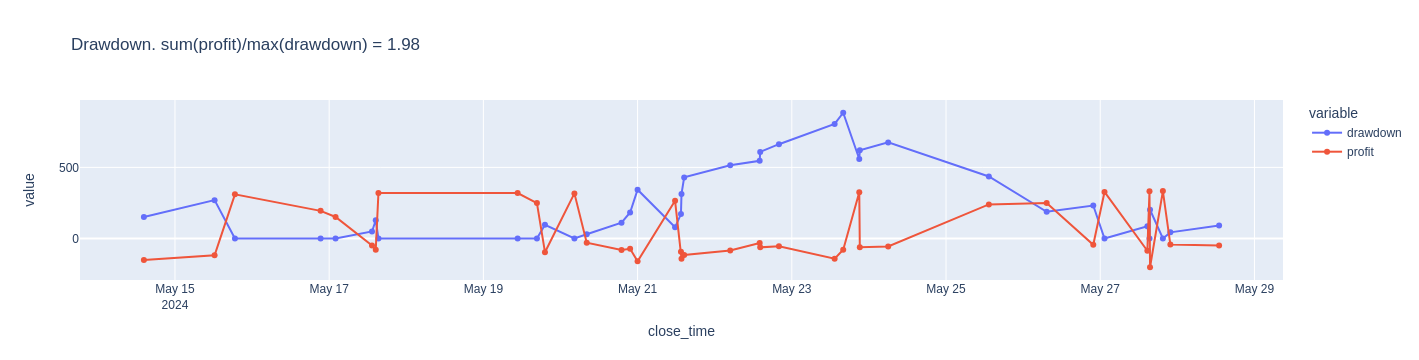

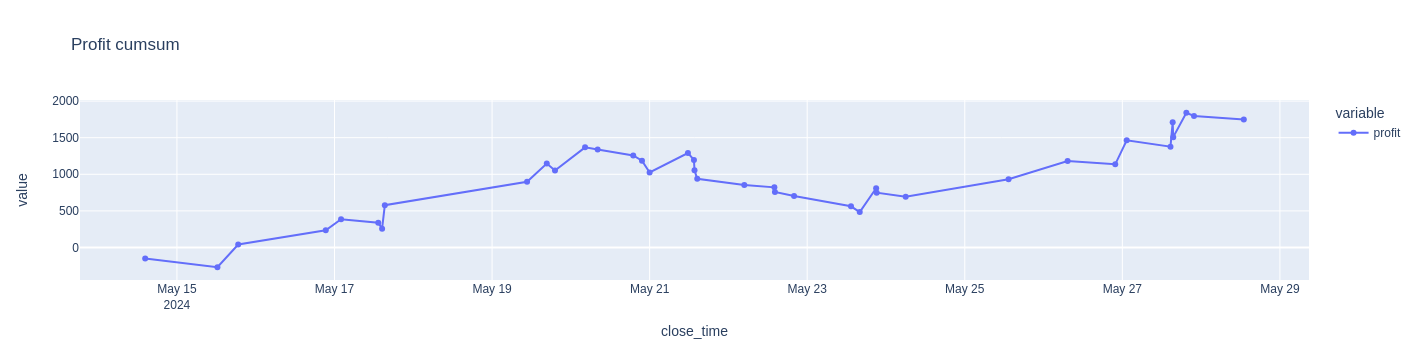

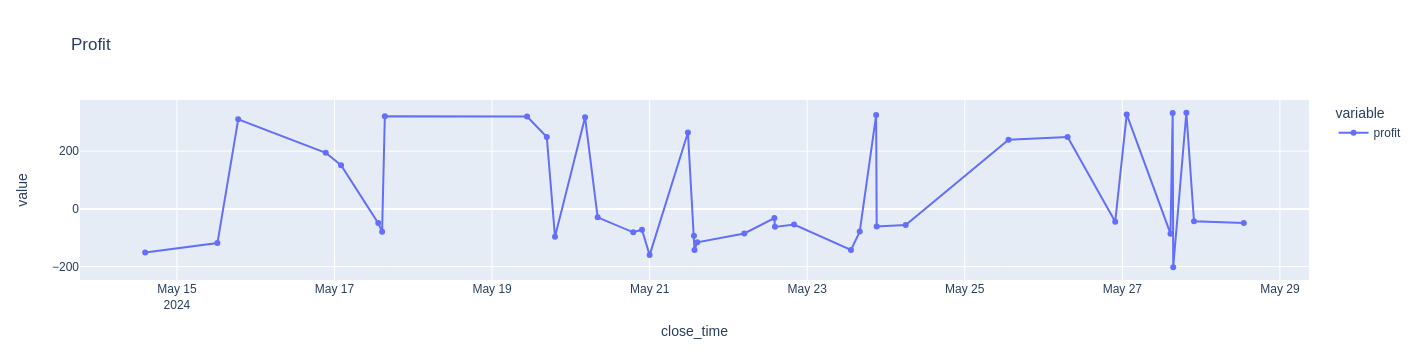

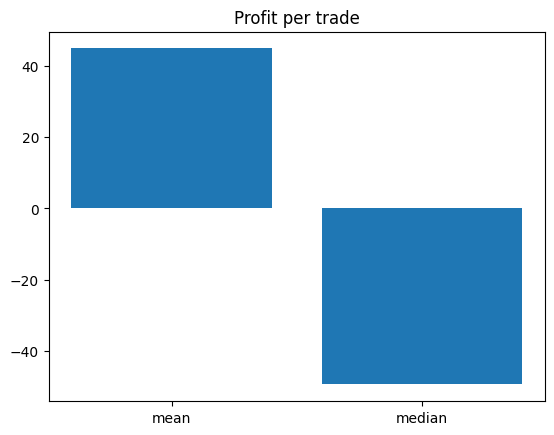

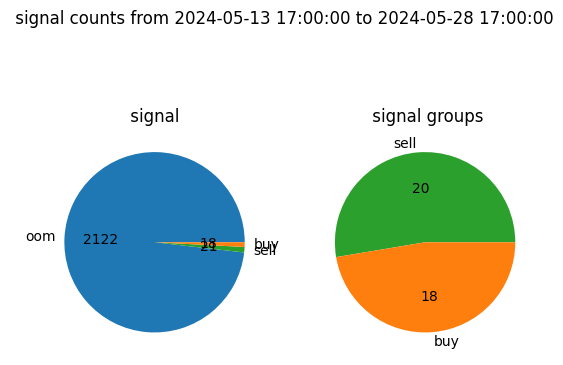

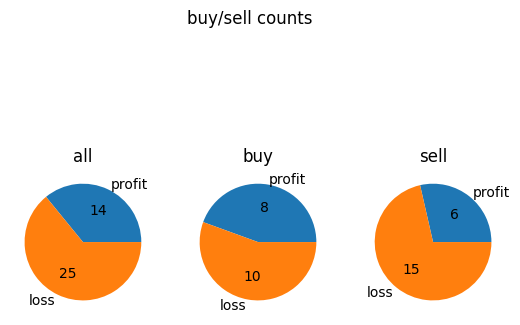

In [49]:
from pytrade2.pytrade2.strategy.signal.SignalByFutLowHigh import SignalByFutLowHigh
import seaborn as sns


def calc_signal_ext(candles, y_test, y_pred):
    """ Using predicted values, create dataframe with signal, stoploss, takeprofit """
    # Combine test with pred
    fut_df = pd.DataFrame(index = y_pred.index)
    fut_df['close'] = candles['close']
    fut_df['fut_low'] = candles['close'] + y_test['fut_low_diff']
    fut_df['fut_high'] = candles['close'] + y_test['fut_high_diff']
    fut_df['fut_low_pred'] = candles['close'] + y_pred['fut_low_diff']
    fut_df['fut_high_pred'] = candles['close'] + y_pred['fut_high_diff']

    # Signal calculator from pytrade2
    signal_calc = SignalByFutLowHigh(profit_loss_ratio=profit_loss_ratio,
                                stop_loss_min_coeff=stop_loss_min_coeff,
                                stop_loss_max_coeff=stop_loss_max_coeff,
                                take_profit_min_coeff=take_profit_min_coeff,
                                take_profit_max_coeff=take_profit_max_coeff,
                                comission_pct=comission_pct,
                                price_presision=price_precision)
    
    # Create df: signal, stoploss, take profit
    signal_df = fut_df[['close', 'fut_low_pred', 'fut_high_pred']]\
            .apply(lambda row: signal_calc.calc_signal(row[0], row[1], row[2]), axis=1, result_type='expand')
    signal_df.columns = ['signal', 'sl', 'tp']    
    signal_df = pd.concat([signal_df, fut_df], axis=1)
    signal_df = with_profit(signal_df)
    signal_df = with_drawdown(signal_df)    
    return pd.concat([signal_df, fut_df], axis=1)
    
def with_profit(signal):
    """ Metric: profit it trade by predicted values """

    # Buy and price keeps above stop loss and goes over tp
    is_buy_profit = (signal['signal'] == 1) & (signal['fut_low'] > signal['sl']) & (signal['fut_high'] >= signal['tp'])
    is_buy_loss = (signal['signal'] == 1) & (~is_buy_profit)
    
    # Sell and price keeps below stop loss and goes below tp
    is_sell_profit = (signal['signal'] == -1) & (signal['fut_high'] < signal['sl']) & (signal['fut_low'] <= signal['tp'])
    is_sell_loss = (signal['signal'] == -1) & (~is_sell_profit)

    #profit = pd.DataFrame(index = signal.index)
    signal['profit'] = 0

    # Buy profit or loss
    signal.loc[is_buy_profit, 'profit'] = signal['tp'] - signal['close'] - (signal['tp']*comission) - (signal['close']*comission)
    signal.loc[is_buy_loss, 'profit'] = signal['sl'] - signal['close'] - (signal['sl']*comission) - (signal['close']*comission)

    # Sell profit or loss
    signal.loc[is_sell_profit, 'profit'] = signal['close'] - signal['tp'] - (signal['close']*comission) - (signal['tp']*comission)
    signal.loc[is_sell_loss, 'profit'] = signal['close'] - signal['sl'] - (signal['close']*comission) - (signal['sl']*comission)
    
    return signal

def with_drawdown(df):
    # todo: remove -10
    #profits = df.loc[df['profit'] != 0, 'profit'][:-10]
    profits = df['profit']
    max_drawdown = 0
    cur_drawdown = 0
    drawdowns = []
        
    for profit in profits.values:
        if profit < 0:
            # Loss - increase drawdown
            cur_drawdown -= profit # increase drawdown
        else:
            # We have profit! Decrease drowdown, or if profit covered previous drawdown, set drawdown to 0.
            cur_drawdown = max(0, cur_drawdown - profit)
        max_drawdown = max(max_drawdown, cur_drawdown)
        drawdowns.append(cur_drawdown)

    df['drawdown'] = drawdowns
    return df

def plot_drawdown(signal_ext):
    drawdown = max(signal_ext['drawdown'])
    profit = sum(signal_ext['profit'])
    ratio = round(profit/drawdown, 2)
    title = f'Drawdown. sum(profit)/max(drawdown) = {ratio}'
    px.line(signal_ext.loc[signal_ext['signal']!=0, ['drawdown', 'profit']], title = title).update_traces(mode='lines+markers').show()

def barplot_profit(signal_ext):
    profit_df = signal_ext.loc[signal_ext['profit']!=0, 'profit']
    mean = profit_df.mean()
    median = profit_df.median()
    
    plt.bar(x=["mean", "median"], height=[mean, median])
    plt.title('Profit per trade');
    plt.show()

    #sns.barplot(x=["mean", "median1"], y=[mean, median]);
    

signal_ext = calc_signal_ext(candles_by_period[target_period], y_test, y_pred)
#signal_ext = with_drawdown(signal_ext)


# Drawdown plot
plot_drawdown(signal_ext)

# Profit cumsumplot
px.line(signal_ext.loc[signal_ext['signal']!=0, 'profit'].cumsum(), title = 'Profit cumsum').update_traces(mode='lines+markers').show()
px.line(signal_ext.loc[signal_ext['signal']!=0, 'profit'], title = f'Profit').update_traces(mode='lines+markers').show()
barplot_profit(signal_ext)

# Pie plots
PlotTool.plot_signal_counts(signal_ext)
PlotTool.plot_buy_sell(signal_ext)

## MLFlow experiment

In [13]:
y_test.info()
y_pred.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2161 entries, 2024-05-13 17:00:00 to 2024-05-28 17:00:00
Freq: 10T
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fut_low_diff   2161 non-null   float64
 1   fut_high_diff  2161 non-null   float64
dtypes: float64(2)
memory usage: 115.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2161 entries, 2024-05-13 17:00:00 to 2024-05-28 17:00:00
Freq: 10T
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fut_low_diff   2161 non-null   float64
 1   fut_high_diff  2161 non-null   float64
dtypes: float64(2)
memory usage: 115.2 KB


In [14]:
import mlflow
from mlflow import MlflowClient

#mlflow.set_tracking_uri('http://localhost:5000')
#mlflow_client = MlflowClient()

#mlflow.set_tracking_uri('http://localhost:5000')
#mlflow_client = MlflowClient()

def new_experiment(mflow_client, experiment_name):
    print(f'Creating new mlflow experiment {experiment_name}')
    experiment_tags = {'project_name': 'pytrade2'}
    artifact_location='s3://pytrade2/mlartifacts'
    experiment = mlflow_client.create_experiment(
        name=experiment_name, tags=experiment_tags, artifact_location=artifact_location
    )    
    return experiment

def ensure_experiment(mlflow_client, experiment_name):
    experiments = mlflow_client.search_experiments(filter_string=f"name = '{experiment_name}' AND tags.project_name='pytrade2'")
    if not experiments:
        experiment = new_experiment(mlflow_client, experiment_name)
    else:
        experiment = experiments[-1]
    return experiment


In [15]:
def calc_metrics():
    """ Metrics to use for evaluation """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    profit_mean = signal_ext.loc[signal_ext['signal'] != 0, 'profit'].mean()
    profit_median = signal_ext.loc[signal_ext['signal'] != 0, 'profit'].median()
    profit_drawdown_ratio = sum(signal_ext['profit'])/max(signal_ext['drawdown'])

    return {
        'profit_drawdown_ratio': profit_drawdown_ratio,
        'profit_mean': profit_mean,
            'profit_median': profit_median,
            "mae": mae, 
            "mse": mse, 
            "rmse": rmse, 
            "r2": r2}

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

if do_log_experiment:
    experiment = ensure_experiment(mlflow_client, experiment_name)
    mlflow.set_experiment(experiment_name)

    
    experiment_tags = {
        'train_size': len(x_train)
    }
    
    metrics = calc_metrics()
    #print(metrics)
    #run_name = f'{experiment_name}_{datetime.now()}'
    
    params = {
        "n_estimators": 100,
        "max_depth": 6,
        "min_samples_split": 10,
        "min_samples_leaf": 4,
        "bootstrap": True,
        "oob_score": False,
        "random_state": 888,
    
        'train_size_rows': len(x_train),
        'history_days': history_days,
        'test_days': test_days,
        'profit_loss_ratio':  profit_loss_ratio,
        'take_profit_min_coeff': take_profit_min_coeff,
        'stop_loss_max_coeff': stop_loss_max_coeff,
        'take_profit_max_coeff': take_profit_max_coeff,
        'stop_loss_min_coeff': stop_loss_min_coeff,
        'comission_pct': comission_pct,
        'features_candles_periods': features_candles_periods,
        'target_period': target_period
    }
    
    
    # Initiate the MLflow run context
    import inspect
    print(inspect.signature(mlflow.sklearn.log_model))
    with mlflow.start_run(run_name = run_name) as run:
        #mlflow.set_tags({'tag': 'val'})
        # Log the parameters used for the model fit
        mlflow.log_params(params)
    
        # Log the error metrics that were calculated during validation
        mlflow.log_metrics(metrics)
    
        # Log an instance of the trained model for later use
        if do_log_model:
            artifact_path = run_name
            mlflow.sklearn.log_model(
                sk_model=model, 
                input_example=x_test,
                artifact_path=artifact_path,
                registered_model_name=model_name
            )


(sk_model, artifact_path, conda_env=None, code_paths=None, serialization_format='cloudpickle', registered_model_name=None, signature: mlflow.models.signature.ModelSignature = None, input_example: Union[pandas.core.frame.DataFrame, numpy.ndarray, dict, list, ForwardRef('csr_matrix'), ForwardRef('csc_matrix'), str, bytes, tuple] = None, await_registration_for=300, pip_requirements=None, extra_pip_requirements=None, pyfunc_predict_fn='predict', metadata=None)


/home/dima/.local/lib/python3.12/site-packages/mlflow/types/utils.py:393: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

Registered model 'MultiOutputRegressorLgb' already exists. Creating a new version of this model...
2024/05/28 20:18:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MultiOutputR